Adapted from:

# Image Reduction Module

**Lecturer:** Dan Perley<br>
**Jupyter Notebook Authors:** Dan Perley, Kishalay De & Cameron Hummels


In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
curpath = os.path.abspath('.')                    # top level directory
dataFolder = os.path.join(curpath, 'data')        # data directory
biasFolder = os.path.join(dataFolder, 'bias')     # bias frames subdirectory
flatFolder = os.path.join(dataFolder, 'flat')     # flat fields subdirectory
sciFolder = os.path.join(dataFolder, 'science')   # science data subdirectory
procFolder = os.path.join(curpath, 'processing')  # processing directory

In [3]:
## Get file lists

os.chdir(sciFolder)
fileList = sorted(glob.glob('*.fits'))
os.chdir(curpath)
biasList = sorted(glob.glob(os.path.join(biasFolder,'*.fits')))
flatList = sorted(glob.glob(os.path.join(flatFolder,'*.fits')))
sciList = [os.path.join(sciFolder, file) for file in fileList]
procList = [os.path.join(procFolder, file).replace('.fits','.proc.fits') for file in fileList]

print('Found',len(biasList),'bias files; ',len(flatList),'flat files; ',len(sciList),'science files')


Found 5 bias files;  5 flat files;  3 science files


Filename: /Users/lockepatton/Desktop/2020-ASTR100/Notes/2020_02_25_Reducing_Data/data/science/acam761.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  extension1    1 ImageHDU        49   (2148, 2501)   int16 (rescales to uint16)   
SIMPLE  =                    T /                                                
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T / File contains extensions                       
RUN     =              2696761 / Run number                                     
IRAFNAME= 'r2696761          ' / IRAF should use this name                      
RUNSET  = '1:1:2696761       ' / i:n:r => Run i of n runs starting at #r        
SYSVER  = 'S15-281           ' / Version of observing system                    
ORIGIN  = 'ING La Palma      ' / Name of obse

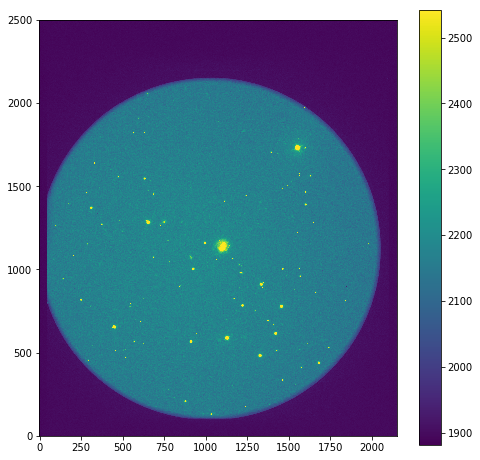

In [4]:
## Open an example FITS file

exampleFile = sciList[0]         # The first science image
HDUList = fits.open(exampleFile) # Open the file
HDUList.info()                   # Print some information about the FITS file structure.  

## Print some header properties

header = HDUList[0].header # Get the header out of the HDU list.
print(repr(header[0:13]))  # Print the first 14 lines of the header (in raw format).
print(repr(header[24:34])) # Print some additional lines
print(repr(header[48:52])) 
print(repr(header[67:71])) 
print(repr(header[129:135])) 
print()
print('The object is:', header['OBJECT'])   # Print the name of the object being observed
print('The filters are:', header['ACAMFILT']) # Print the names of the optical filters in the light path.
print('The exposure time is:', header['EXPTIME'])  # Print the exposure time


## Get and display the image data

data = HDUList[1].data  # Get the data array (a simple numpy array) from the first extension.

mean, median, std = sigma_clipped_stats(data) # get some image statistics
plt.figure(figsize=(8,8))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 3*std, origin='lower')
plt.colorbar()
plt.show()

***

## Creating a bias frame

The detector image comes with an electronic offset introduced by the voltages applied to the the semiconductor-based detector.   This can be clearly seen in the science image above: even the unexposed parts of the detector have an apparent signal level of about 1900 counts.  We have to remove this offset to get real counts received by the detector. 

Different bias-removal methods are employed by different detectors.  In most cases, we record a set of images ("bias frames") with zero exposure time, so that the recorded image reflects *only* the intrinsic offsets in the detector (the detector does not receive any photons if the exposure time is zero).  To reduce detector noise and to remove cosmic ray contamination, we usually take many bias frames and average them together using median-combination.  (Even though the exposure time is zero, cosmic rays can strike the detector during readout.)

1897.1078187040162 1897.0 2.8254707076165957
1897.1356444257967 1897.0 2.816450285089329
1897.145840135028 1897.0 2.814593101451918
1897.092508070717 1897.0 2.814481100114875
1897.0668936325796 1897.0 2.8129912795749363


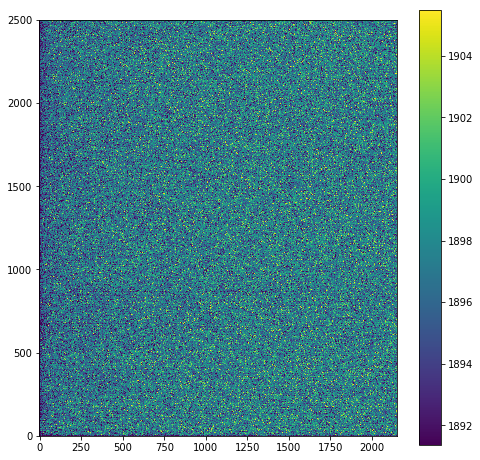

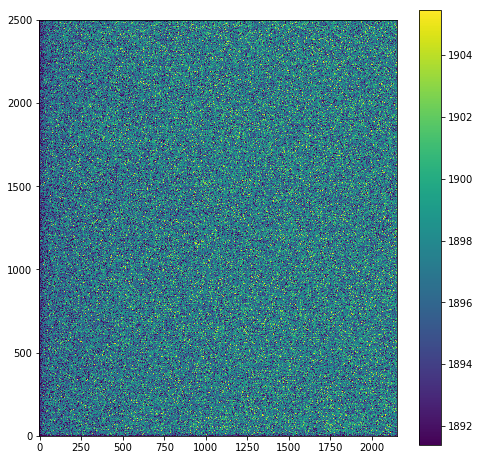

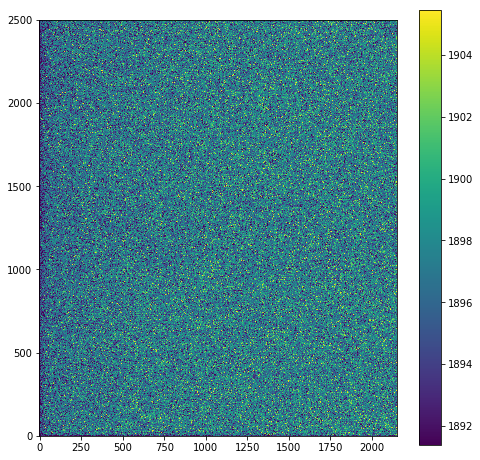

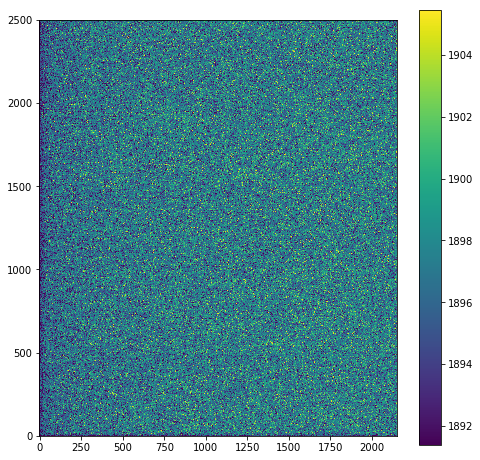

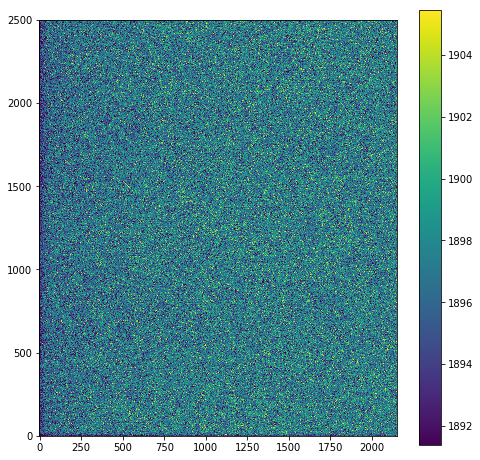

In [5]:
# Display the first bias image and determine its clipped standard deviation.

for BiasFile in biasList:
    HDUList = fits.open(BiasFile)
#     HDUList.info()

    bias = HDUList[1].data
    mean, median, std = sigma_clipped_stats(bias)
    
    print(mean,median,std)
    
    plt.figure(figsize=(8,8))
    plt.imshow(bias, vmin = median - 2*std, vmax = median + 3*std, origin='lower')
    plt.colorbar()

In [6]:
## Median-combine the bias frames to make a master bias

# Create a 3D array to store all the bias files together.
ny = 2501
nx = 2148
numBiasFiles = len(biasList)
biasImages = np.zeros((ny, nx, numBiasFiles))

# Add the files to the array
for i in range(numBiasFiles):
        HDUList = fits.open(biasList[i])     # Open the file
        biasImages[:,:,i] = HDUList[1].data  # Load the data into the appropriate layer
        HDUList.close()                      # Close the file

# Create the master bias frame by doing a median combination for each pixel over all layers
masterBias = np.median(biasImages, axis=2)

1897.1225246167803 1897.0 1.5592892457870324


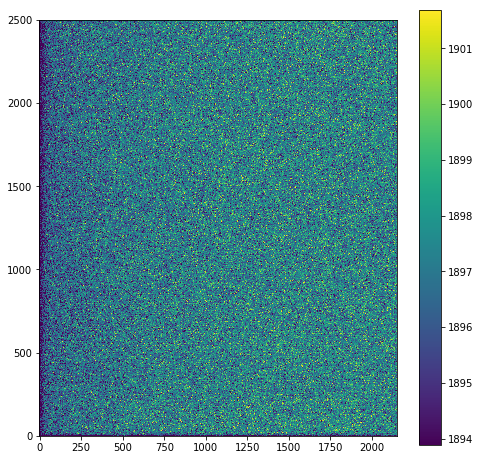

In [7]:
mean, median, std = sigma_clipped_stats(masterBias)
print(mean,median,std)

plt.figure(figsize=(8,8))
plt.imshow(masterBias, vmin = median - 2*std, vmax = median + 3*std, origin='lower')
plt.colorbar()
plt.show()

It should look pretty similar to the individual bias frame, but with lower noise.  Read noise is generally negligible compared to the sky noise for broadband imaging observations such as this one, so this isn't a major consideration here.  However, for narrowband observations or for spectroscopy this may not be the case, so it's always a good idea to take many bias frames if possible.

***

## Creating a flat field

The image recorded on the detector $I(x,y)$ is a product of the true brightness distribution on the sky $S(x,y)$ and the response of the telescope optics and detector in different parts of the image $F(x,y)$. with any bias signal added: i.e.: 

$S(x,y) = F(x,y) I(x,y) + B(x,y)$.  

We already have $B(x,y)$ thanks to our bias frames, but we also need to determine $F(x,y)$ to reconstruct $S(x,y)$.

To do this, we expose the detector to a uniform light source -- this can either be a uniformly illuminated part of the telescope dome or the twilight sky (the assumption is that the sky is uniformly bright over a small field of view).

19693.376869177842 29633.0 13966.621755518367
19711.831663610163 29659.0 13981.422133922373
19602.706294018706 29500.0 13895.210410117646
19654.87310829858 29571.0 13936.77307815128
19613.959110210664 29512.0 13904.437506361068


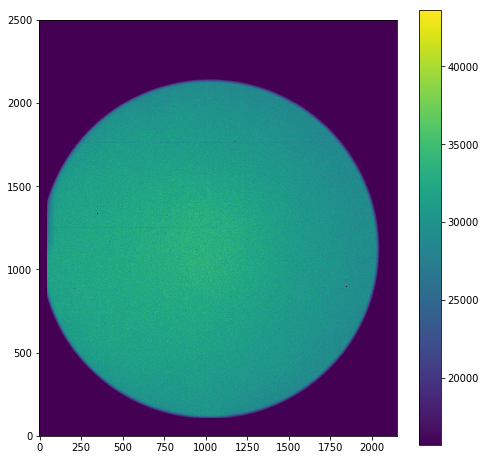

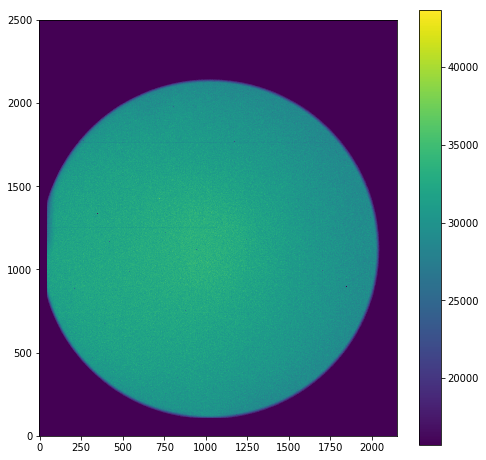

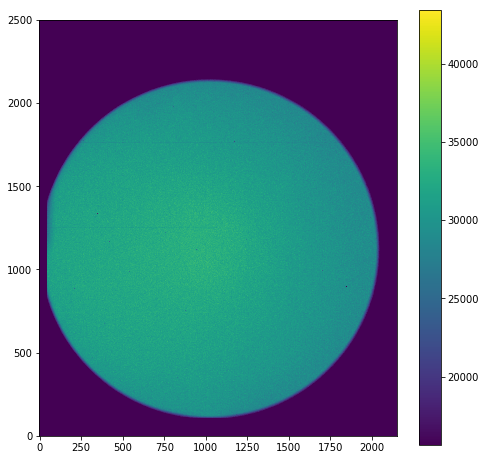

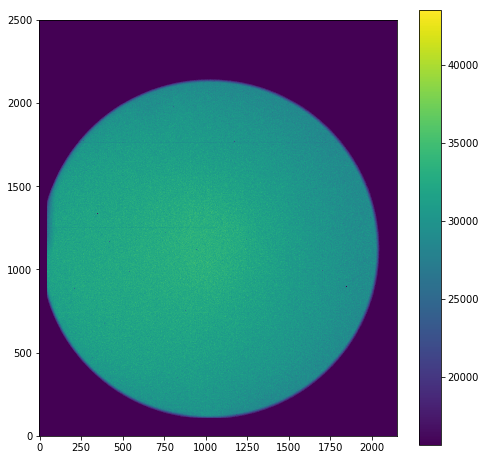

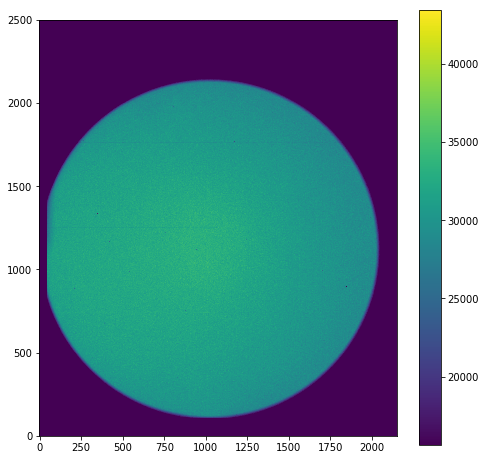

In [8]:
## EXERCISE 3:  Display the first flat-field image.

for FlatFile in flatList:
    HDUList = fits.open(FlatFile)
#     HDUList.info()

    flat = HDUList[1].data
    mean, median, std = sigma_clipped_stats(flat)
    
    print(mean,median,std)
    
    plt.figure(figsize=(8,8))
    plt.imshow(flat, vmin = median - 1*std, vmax = median + 1*std, origin='lower')
    plt.colorbar()

In [9]:
## Load and normalize the flat fields in preparation for making a master flat field.

# Set up the 3D array
numFlatFiles = len(flatList)
flatImages = np.zeros((ny, nx, numFlatFiles))

# Load the files into the array, with bias subtraction and normalization
for i in range(numFlatFiles):
        # Load the data from the fits file
        HDUList = fits.open(flatList[i])
        data = HDUList[1].data * 1. # Convert to floating point
        HDUList.close()

        # Bias-subtract, normalize, and add to the array layer
        data -= masterBias
        normfactor = np.median(data[500:1600,500:1600])
        print('normfactor:',normfactor)
        flatImages[:,:,i] = data / normfactor
        
#         plt.imshow(data)
#         plt.show()

normfactor: 30237.0
normfactor: 30274.0
normfactor: 30070.0
normfactor: 30175.0
normfactor: 30097.0


(2501, 2148, 5)
(2501, 2148)
(2501, 2148)
(2501, 2148)
(2501, 2148)
(2501, 2148)
0.5886063353189417 0.9175257731958762 0.46189507600839014


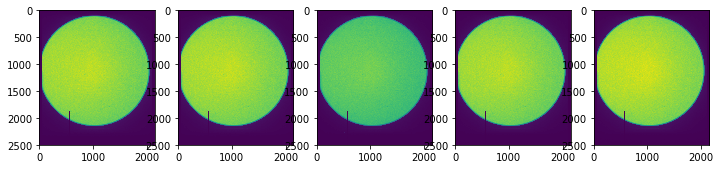

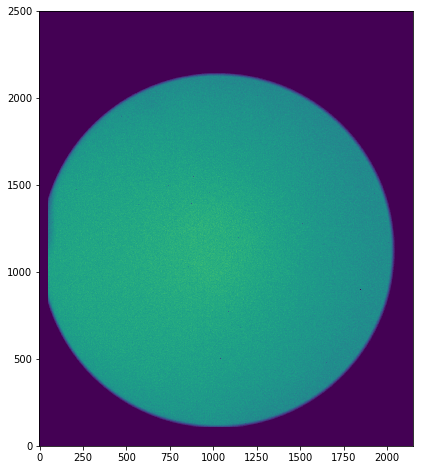

In [10]:
## EXERCISE 5: Median-combine the flat field layer array into a master flat and display it.
print(flatImages.shape)

fig, ax = plt.subplots(1,numFlatFiles, figsize=(12,4))

for i in range(numFlatFiles):
    data = flatImages[:,:,i]
    print(data.shape)
    ax[i].imshow(data)
    
masterFlat = np.median(flatImages,axis=2)

mean, median, std = sigma_clipped_stats(masterFlat)
    
print(mean,median,std)

plt.figure(figsize=(8,8))
plt.imshow(masterFlat, vmin = median - 1*std, vmax = median + 1*std, origin='lower')
# plt.imshow(masterFlat, vmin = 28000, vmax = 35000, origin='lower')
plt.show()

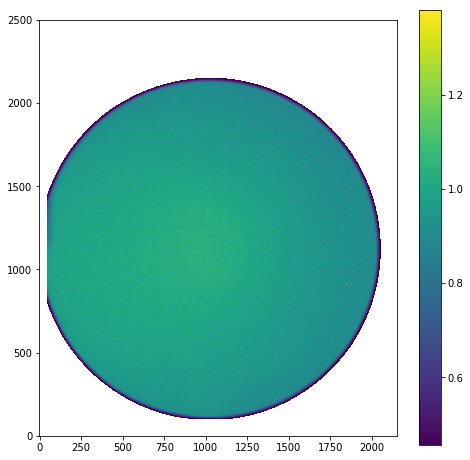

In [11]:
## Set the unexposed pixels to NaN, and display again

masterFlatFixed = np.copy(masterFlat) # Use 'copy' to preserve the original masterFlat
if np.any(masterFlat < 0.2):
        # Set all flat-field values lower than 0.2 to NaN
        masterFlatFixed[masterFlat < 0.2] = float('NaN') 

plt.figure(figsize=(8,8))
#scale the image according to its statistics
plt.imshow(masterFlatFixed, vmin = median - std, vmax = median + 1*std, origin='lower')
plt.colorbar()
plt.show()

At this point, we have the necessary calibration images to reduce science images and visualize the true brightness distribution on the sky.  Remember that the observed intensity on the detector is:

$I(x,y) = F(x,y) \,  S(x,y) + B(x,y)$

We now have to retrieve $S(x,y)$ from $I(x,y)$, by inverting this equation, i.e.:

$S(x,y) = \frac{I(x,y)-B(x,y)}{F(x,y)}$

## Pre-processing science frames

Now we will apply the bias flat calibrations to the science frames and write processed science frames to disk for further processing.  To simplify matters, we will write these processed files in 'simple' FITS format, combining the primary header data with the (bias- and flat-corrected) image data in the FITS extension for each file.

In [12]:
## Bias subtract and flat-field all science frames and write out pre-processed files.

numSciFiles = len(sciList)
print('Found %d science files'%numSciFiles)

for i in range(numSciFiles):
        # Read in the FITS data.
        HDUList = fits.open(sciList[i])
        primaryHeader = HDUList[0].header
        imageData = HDUList[1].data    
        HDUList.close()
        
        # Correct for the bias and flats here
        procData = (imageData - masterBias) / masterFlatFixed
        
        # Prepare the output FITS structure in simple format
        procHDU = fits.PrimaryHDU(procData)  # Create a new HDU with the processed image data
        procHDU.header = primaryHeader       # Copy over the header from the raw file
        procHDU.header.add_history('Bias corrected and flat-fielded') # Add a note to the header

        # Write the reduced frame to disk
        print(sciList[i].split('/')[-1],'->',procList[i].split('/')[-1])
        procHDU.writeto(procList[i], overwrite=True)

Found 3 science files
acam761.fits -> acam761.proc.fits
acam762.fits -> acam762.proc.fits
acam763.fits -> acam763.proc.fits


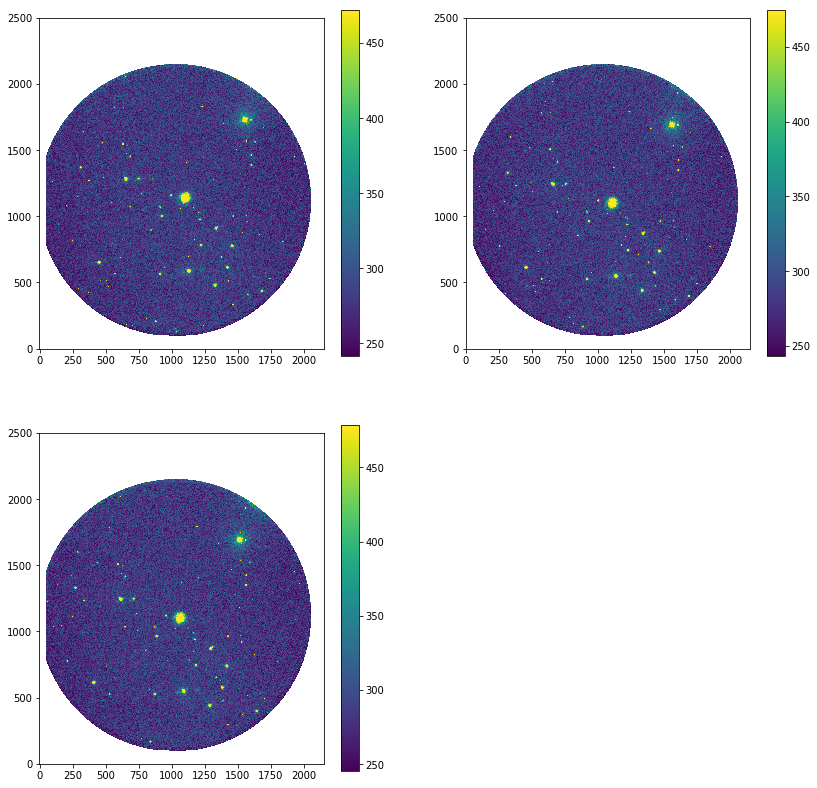

In [13]:
# Inspect the processed science files

plt.figure(figsize=(14,14))
for i in range(numSciFiles):
        procHDU = fits.open(procList[i])
        procData = procHDU[0].data
        procHDU.close()
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            mean, median, std = sigma_clipped_stats(procData)
            
        plt.subplot(2,2,1+i)
        plt.imshow(procData, vmin = median - 2*std, vmax = median + 10*std, origin='lower')
        plt.colorbar()